In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# !pip install deepxde

# from deepxde.backend.set_default_backend import set_default_backend
# set_default_backend("tensorflow")

import deepxde as dde


Using backend: tensorflow



Enable just-in-time compilation with XLA.



In [310]:
brench = 100

def activation1(x):
  return tf.math.tanh(x)

kernel_init = 'glorot_uniform'

inputs1 = tf.keras.layers.Input(shape = (1))
inputs2 = tf.keras.layers.Input(shape = (1))

inp = tf.concat([inputs1,inputs2],1)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init, use_bias=False)(inp)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)
x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)

outputs = tf.keras.layers.Dense(1 ,activation='linear')(x) * 10
NN = tf.keras.Model([inputs1,inputs2], outputs)


In [311]:
# NN.save('./reaction-diffusion.h5')

In [312]:
# NN = tf.keras.models.load_model('./reaction-diffusion.h5')

In [313]:
T = 1
L = 1
N = 50

a = (np.geomspace(1,1001,N) - 1) * (T/1000)
b = np.linspace(0,L,N)
t = []
x = []
for j in a:
  for i in b:
    t.append(j)
    x.append(i)

train_t = np.array(t).reshape(-1,1)
train_x = np.array(x).reshape(-1,1)


a = np.linspace(0,T,10*N)
b = np.linspace(0,L,10*N)

t = []
x = []
for j in a:
  for i in b:
    t.append(j)
    x.append(i)

test_t = np.array(t).reshape(-1,1)
test_x = np.array(x).reshape(-1,1)

In [314]:
# train_t = tf.constant(train_t, dtype=tf.float32)
# train_x = tf.constant(train_x, dtype=tf.float32)
# train_t = tf.data.Dataset.from_tensor_slices(train_t)
# train_x = tf.data.Dataset.from_tensor_slices(train_x)

# train_t = train_t.batch(30)
# train_x = train_x.batch(30)

In [338]:
def pde_system(t,x, net):
    t = tf.constant(t, dtype = tf.float32) 
    x = tf.constant(x, dtype = tf.float32) 
    
    D = 30
    k = 1000

    with tf.GradientTape() as tape:
      tape.watch(x)
      with tf.GradientTape() as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape3:
          tape3.watch(t)

          u = net([t,x])
          u_t = tape3.gradient(u, t)
        u_x = tape2.gradient(u, x)
      u_xx = tape.gradient(u_x, x)
    
    pde_loss = u_t - D * u_xx + k * u
    # pde_loss = tf.math.log(1+tf.square(pde_loss))
    pde_loss = tf.square(pde_loss)
    pde_loss = tf.reduce_mean(pde_loss)

    BC1_t = tf.constant(np.linspace(0, T,20).reshape(-1,1), dtype = tf.float32)
    BC1_x = tf.constant(np.linspace(0,0,20).reshape(-1,1), dtype = tf.float32)

    BC1 = net([BC1_t,BC1_x]) - 10
    # BC1_loss = tf.math.log(1+tf.square (BC1))
    BC1_loss = tf.square (BC1)
    BC1_loss = tf.reduce_mean(BC1_loss)

    BC2_t = tf.constant(np.linspace(0,T,20).reshape(-1,1), dtype = tf.float32)
    BC2_x = tf.constant(np.linspace(L,L,20).reshape(-1,1), dtype = tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(BC2_x)

      BC2 = net([BC2_t,BC2_x])

      BC_u_x = tape.gradient(BC2, BC2_x)

    # BC2_loss = tf.math.log(1+tf.square(BC_u_x))
    BC2_loss = tf.square(BC_u_x)
    BC2_loss = tf.reduce_mean(BC2_loss)

    IC_t = tf.constant(np.linspace(0,0,20).reshape(-1,1), dtype = tf.float32)
    IC_x = tf.constant(np.linspace(0.01 * L ,L,20).reshape(-1,1), dtype = tf.float32)
    
    IC = net([IC_t, IC_x])
    IC_loss = tf.square(IC)
    IC_loss = tf.reduce_mean(IC_loss)
    return pde_loss, BC1_loss, BC2_loss, IC_loss

In [339]:
# train_loss_record = []
# lr = 1e-3

# optm = tf.keras.optimizers.Adam(lr=lr)
# for itr in range(5000):
#   with tf.GradientTape() as tape:
#     pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)
#     train_loss = 1e-4 * pde_loss + BC1_loss + BC2_loss  + IC_loss
    
#     grad_w = tape.gradient(train_loss, NN.trainable_variables)
#     optm.apply_gradients(zip(grad_w, NN.trainable_variables))

#   train_loss_record.append(train_loss)

#   if itr % 100 == 0:
#       print(f"{itr} : {pde_loss.numpy():.3e},  {BC1_loss.numpy():.3e},  {BC2_loss.numpy():.3e},  {IC_loss.numpy():.3e}")
#       lr = lr * 0.94
#       optm.learning_rate = lr


In [340]:
train_loss_record = []

weight1 = 1e-5
weight2 = 1.
weight3 = 1.
weight4 = 1.

lr = 1.1e-4

optm = tf.keras.optimizers.Adam(learning_rate=lr)
for itr in range(20000):
  with tf.GradientTape() as tape2:
    
    if itr % 100 == 0:
      lr = lr * 0.98
      optm.learning_rate = lr

      with tf.GradientTape(persistent=True) as tape:
        tape.watch(NN.trainable_variables)

        pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)

      grad1 = tape.gradient(pde_loss, NN.trainable_variables)
      grad2 = tape.gradient(BC1_loss, NN.trainable_variables)
      grad3 = tape.gradient(BC2_loss, NN.trainable_variables)
      grad4 = tape.gradient(IC_loss, NN.trainable_variables)

      del tape

      abc = tf.constant([[0.]])
      for i in grad1:
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a1 = tf.sqrt(tf.reduce_mean(abc)).numpy()

      abc = tf.constant([[0.]])

      for i in grad2:
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a2 = tf.sqrt(tf.reduce_mean(abc)).numpy()
      a_all = a1 + a2

      abc = tf.constant([[0.]])
      for i in grad3:
        if i is None:
          continue
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a3 = tf.sqrt(tf.reduce_mean(abc)).numpy()
      a_all = a_all + a3

      abc = tf.constant([[0.]])
      for i in grad4:
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a4 = tf.sqrt(tf.reduce_mean(abc)).numpy()
      a_all = a_all + a4

      if itr == 0:
        # weight1 = 1 - a1/a_all
        # weight2 = 1 - a2/a_all
        # weight3 = 1 - a3/a_all
        # weight4 = 1 - a4/a_all
        pass
      else:
        weight1 = weight1 - 0.2 * (weight1 - (1 - a1/a_all))
        weight2 = weight2 - 0.2 * (weight2 - (1 - a2/a_all))
        weight3 = weight3 - 0.2 * (weight3 - (1 - a3/a_all))
        weight4 =  weight4 - 0.2 * (weight4 - (1 - a4/a_all))

    else:
       pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)

    train_loss = weight1 *0.8* pde_loss + weight2 * BC1_loss + weight3 * BC2_loss  + weight4 * IC_loss

    grad_w = tape2.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))

  train_loss_record.append(pde_loss + BC1_loss + BC2_loss  + IC_loss)

  if itr % 100 == 0:
      print(f"{itr} : {pde_loss.numpy():.3e},  {BC1_loss.numpy():.3e},  {BC2_loss.numpy():.3e},  {IC_loss.numpy():.3e}")
      print(weight1, weight2, weight3, weight4 )
      print((1 - a1/a_all) , (1 - a2/a_all) , (1 - a3/a_all) , (1 - a4/a_all) )


0 : 1.545e+07,  1.553e+00,  8.145e-04,  1.275e+00
1e-05 1.0 1.0 1.0
2.980232238769531e-07 0.9999998519993198 0.9999999996848056 0.9999997950871204
100 : 1.830e+04,  2.200e+00,  7.292e-02,  1.112e+00
1.5545948028564452e-05 0.9999968925534631 0.9999999136218548 0.9999956479605316
3.7729740142822266e-05 0.9999844627673156 0.9999995681092742 0.9999782398026582
200 : 6.561e+03,  2.167e+00,  6.034e-02,  1.121e+00
2.3284803771972654e-05 0.9999930230834434 0.999999817446535 0.9999902750329056
5.424022674560547e-05 0.9999775452033646 0.9999994327452555 0.9999687833224016
300 : 2.906e+03,  2.169e+00,  4.659e-02,  1.118e+00
3.598471557617187e-05 0.9999872113979072 0.9999996921199445 0.9999822208516707
8.678436279296875e-05 0.9999639646557625 0.9999991908135826 0.9999500041267311
400 : 1.720e+03,  2.173e+00,  3.525e-02,  1.112e+00
5.5609862609863275e-05 0.9999786328977615 0.9999995323403612 0.9999703112579882
0.0001341104507446289 0.9999443188971782 0.9999988932220276 0.9999226728832582
500 : 1.17

KeyboardInterrupt: 

9468 : 1.566e+01,  2.055e+00,  9.737e-03, 1.320e+00
68.869156 0.33940142 0.0040946016 0.5086883
0.012222766876220703 0.9951320299878716 0.9999412719080283 0.9927039807662368
1.613874932412976e-05


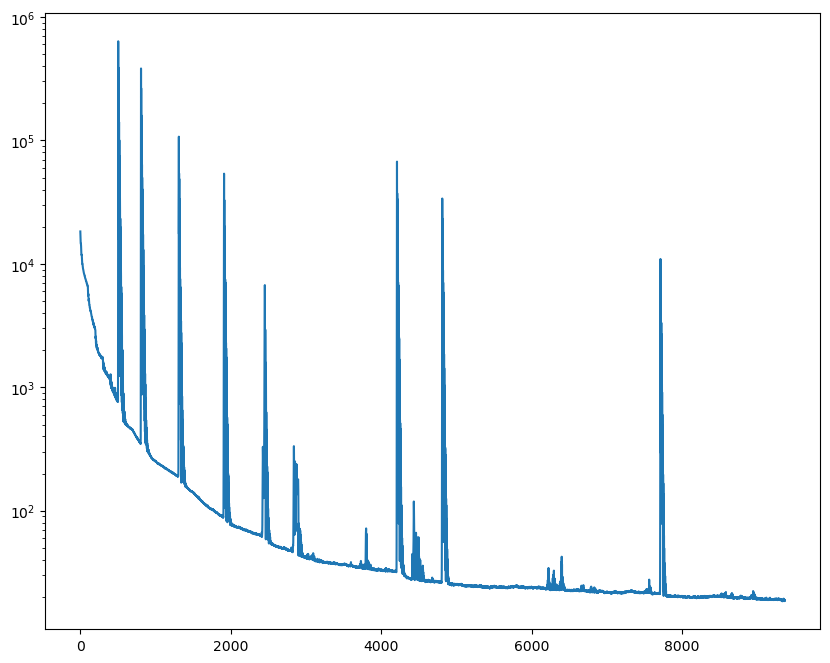

In [341]:
print(f"{itr} : {pde_loss.numpy():.3e},  {BC1_loss.numpy():.3e},  {BC2_loss.numpy():.3e}, {IC_loss.numpy():.3e}")
print(a1,a2,a3,a4)
print((1 - a1/a_all) , (1 - a2/a_all) , (1 - a3/a_all) , (1 - a4/a_all) )
print(lr)

plt.figure(figsize = (10,8))
plt.yscale('log')
plt.plot(train_loss_record[100:])
plt.show()

In [342]:
pred = NN.predict([test_t,test_x],batch_size=len(test_t))

a = pred.reshape(10*N,10*N)

b1 = []
b2 = []
b3 = []
b4 = []
for i in a:
  b1.append(i[1])
  b2.append(i[int(3*N)])
  b3.append(i[int(8*N)])
  b4.append(i[10*N-1])

1/1 [==============================] - 0s 22ms/step


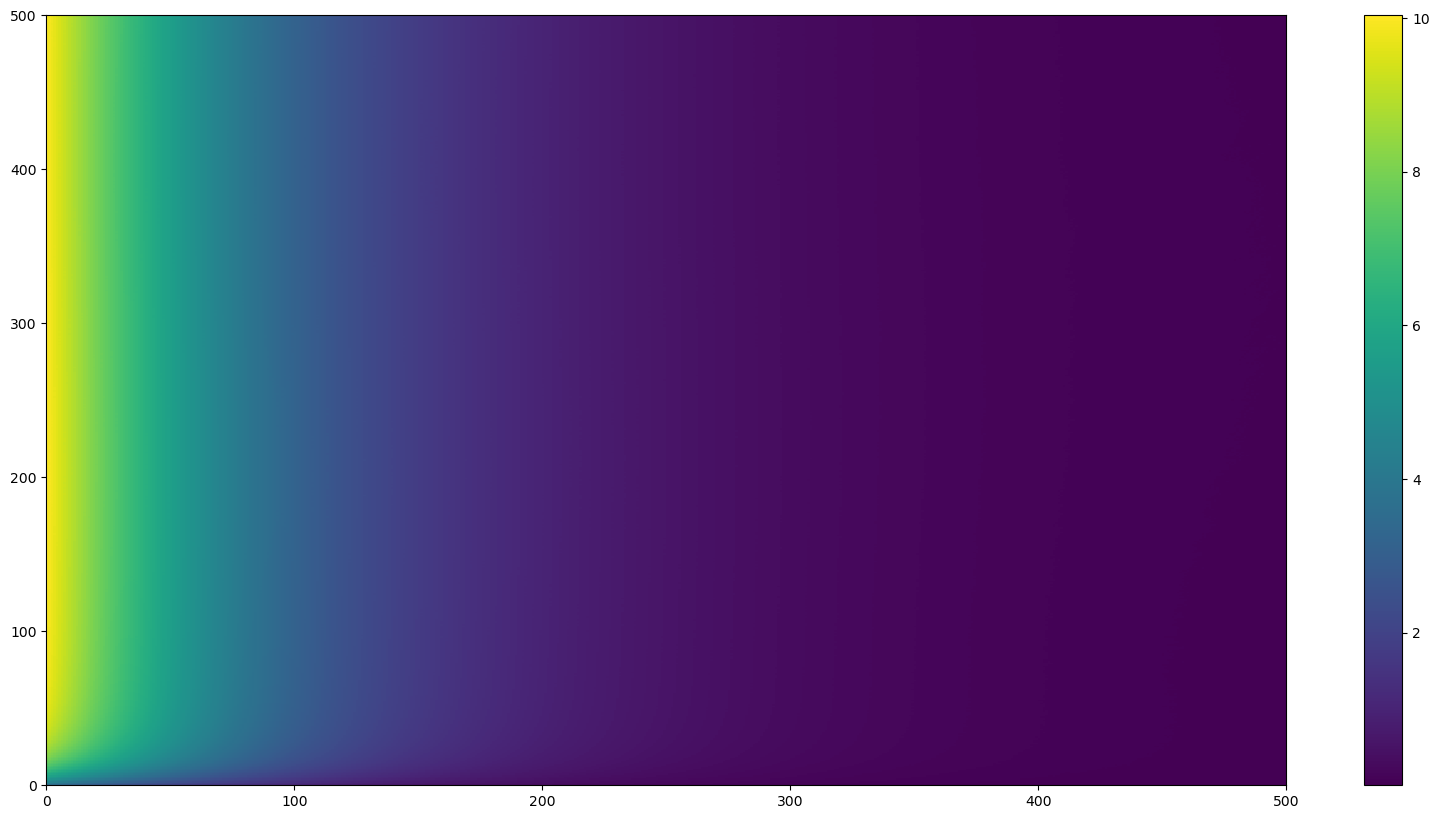

In [343]:
plt.figure(figsize=(20,10))
plt.pcolor(a)
plt.colorbar()

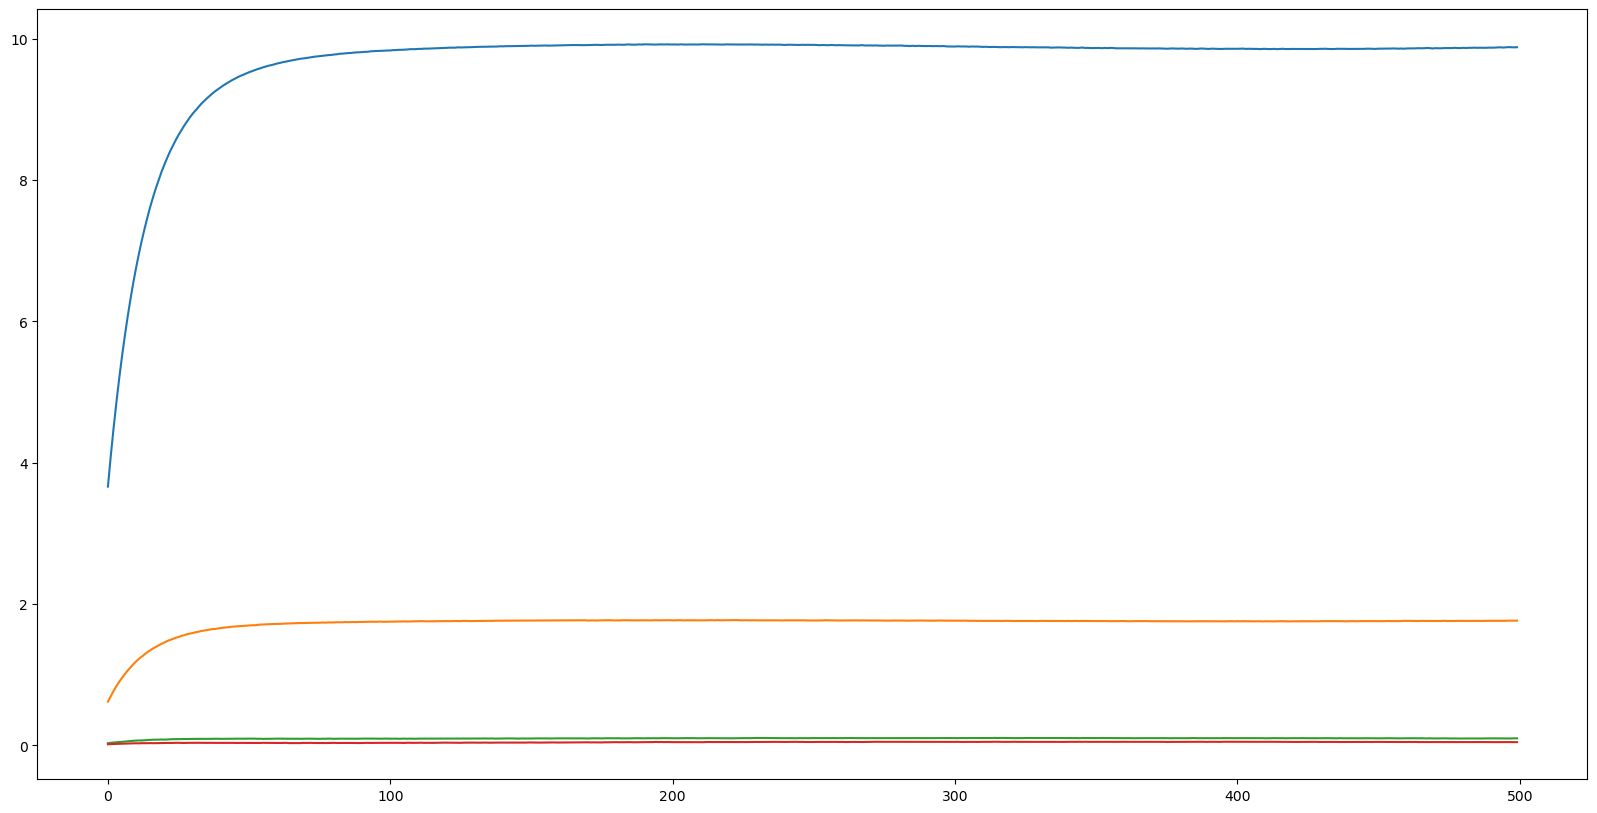

In [344]:
plt.figure(figsize=(20,10))
plt.plot(b1)
plt.plot(b2)
plt.plot(b3)
plt.plot(b4)

In [333]:
def loss_val():
    pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)
    train_loss = pde_loss + BC1_loss + BC2_loss  + IC_loss
    return train_loss


In [334]:
result = dde.optimizers.tfp_optimizer.lbfgs_minimize(NN.trainable_variables, loss_val)

pde_system(train_t,train_x, NN)

(<tf.Tensor: shape=(), dtype=float32, numpy=32.2691>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5529358>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00081454136>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.2754074>)

In [335]:
pred = NN.predict([test_t,test_x],batch_size=len(test_t))

a = pred.reshape(10*N,10*N)

b1 = []
b2 = []
b3 = []
b4 = []
for i in a:
  b1.append(i[1])
  b2.append(i[int(5*N)])
  b3.append(i[int(9*N)])
  b4.append(i[10*N-1])

1/1 [==============================] - 0s 19ms/step


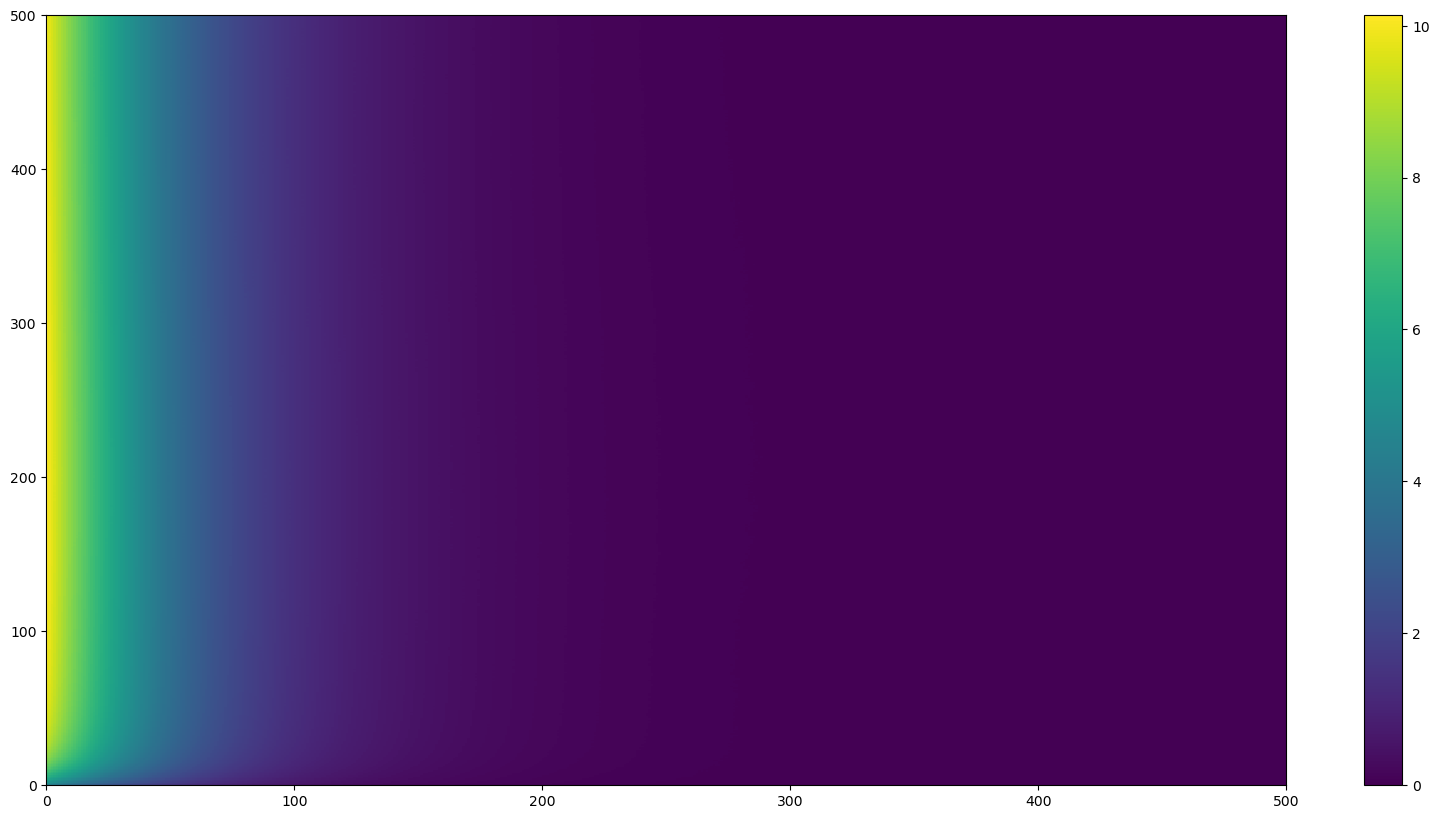

In [336]:
plt.figure(figsize=(20,10))
plt.pcolor(a)
plt.colorbar()

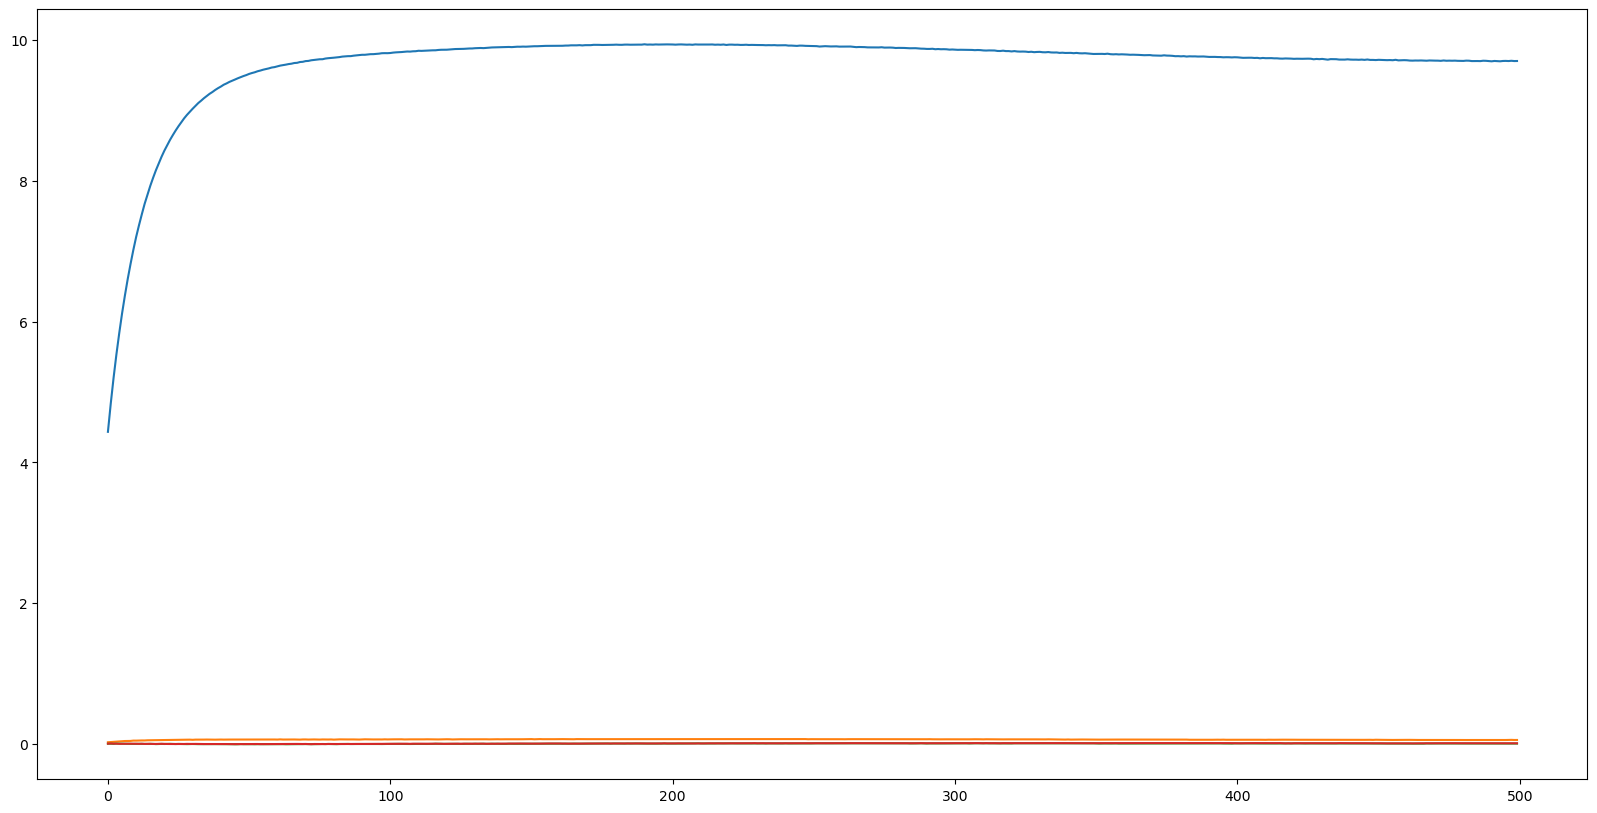

In [337]:
plt.figure(figsize=(20,10))
plt.plot(b1)
plt.plot(b2)
plt.plot(b3)
plt.plot(b4)